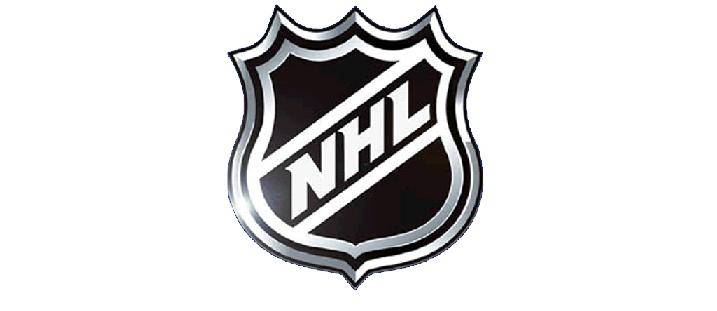

# Predicting NHL Wins

By: Jillian Komskis, Joseph Perez, and Kenneth Thomas


An outline of the project is as follows: 
1.  Objective
2.  Load/filter the data                                                                  
3.  Data correlation (heat map)
4.  Seperate train/test sets
5.  Feature scaling 
6.  Models: LR, 2nd-degree, 7th-degree
7.  Regularization Models
8.  Comparisons
9.  Remove short-handed variables
10.  New comparisons
11. Extra Predictions
12. Model Application
13. Conclusion

## Objective

Our objective is to create a model that will predict the amount of wins an NHL team will have in an upcoming season based off certain inputs (feature variables). We have decided to use the following feature variables in our models: Goals-For, Goals-Against, Short-Handed Goals-For, Short-Handed Goals-Against, Penalties-in-Minutes, PowerPlay Percentage, and Penalty-Kill Percentage.

We will focus our efforts on exploring team data during the seasons that Gary Bettman was commissioner of the National Hockey League (1993 – present) and in which 82 games were played, up until the data’s 2011 limitation. We will remove the 1993 season since teams in the NHL still played 84 games in Bettman’s first season as commissioner. We have also removed the shortened 1994 lockout season as there were only 48 games played that season. In effect, our data begins with the 1995 season. There is no data for the 2004 season since there were no games played due to a lockout.

## Data Preprocessing

### Importing the necessary libraries

In [97]:
# insert inline statement to make sure plots are visible
%matplotlib inline
#this code was taken from the SLR class demo
#in Jupyter, the '%' symbol is a "magic command". This prompt enaples matplotlib to work interactively.


# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#this code was also taken from the SLR class demo
#we are importing the numpy and pandas packages so that we may use the functions that come with these modules.
#we imported matplotlib.pyplot because we will be doing a lot of plotting, and the shorthand 'plt' makes it easier 
#than having to type out matplotlib.pyplot every time we want to use it
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
#this code was taken from the Applying Learning Algorithms Class Demo
#these are tools from the sklearn package that we can utilize later in the assignment
#sklearn makes it easier to produce statistical models since the functions are pre-packaged
from sklearn.model_selection import train_test_split
#This code was also take from the Applying Learning Algorithms Class Demo
#this code will allow us to set aside a test set from our data to test the accuracy of the training set
import csv #imports the csv reading and writing module
import seaborn as sns #Taken from the Bank Marketing Logistic example, allows us to create a heatmap
sns.set(style='white')
sns.set(style='whitegrid',color_codes=True)
from sklearn.metrics import mean_squared_error
#This code was taken from http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html

### Filtering the Data

The following code pulls the data from the computer and then filters the relevant rows (from 1995 - 2011)

In [98]:
#this code was written on our own
with open('C:\\Users\\admin\\Desktop\\MS-BA\\Teams - NHL.csv', 'r') as nhl_file:
    with open('C:\\Users\\admin\\Desktop\\MS-BA\\NHL Filtered.csv','w') as nhl_filtered:
        for line in nhl_file:
            line_list = []
            line_list += line.split(',') #this is splitting each line into a list with each item signified by a 
                                         #separation by commas
            try:
                if int(line_list[0]) >= 1995: #we want the line for years after 1995
                    if int(line_list[8] == '82'): #doesn't actually do anything, but is a good safety. Makes sure that 
                                                  #we only use seasons with 82 games
                        print(line.strip(), file=nhl_filtered)
                    else:
                        continue
                else:
                    continue
            except ValueError: #we are handling ValueErrors exceptions to deal with the title rows
                print(line.strip(), file=nhl_filtered)


### Data Insertion
We are inserting columns for Goal Differential, Power Play Percentage, and Penalty Kill Percentage because we believe that these features may be valuable in predicting team wins.

In [99]:
all_list = []
with open('C:\\Users\\admin\\Desktop\\MS-BA\\NHL Filtered.csv','r+') as nhl_filtered:
    for i in nhl_filtered:
        all_list += [i.strip().split(',')]
        
    for k in all_list: #this code was written by hand to create the GoalDif category. It takes the goals for and 
                       #subtracts it from goals against
        try:
            GF = int(k[16])
            GA = int(k[17])
            goal_dif = GF - GA
            k.insert(18,goal_dif) #inserts the column at the 18th index
        except ValueError:
            k.insert(18,'GoalDif') #for exceptions (the column heading line), it inserts a column heading for the 
                                   #category
            pass
            
    for k in all_list: #this code was written by hand to create the powerplay percentage category. It takes powerplay 
                       #goals and divides it by the total number of powerplay chances
        try:
            PPG = int(k[22])
            PPC = int(k[23])
            PPP = PPG/PPC * 100 #gets it as a percentage
            k.insert(24,PPP) #inserts a column at the 24th index
        except ValueError:
            k.insert(24,'PP%') #for exceptions (the column heading line), it inserts a column heading for the category
            pass
        
    for k in all_list: #this code was written by hand to create the penalty kill percentage category. It takes Pentaly
                       #Kill goals allowed and divides it by the total number of times the team was shorthanded
        try:
            PKG = int(k[26])
            PKC = int(k[27])
            PKP = PKG/PKC * 100 #gets it as a percentage
            k.insert(28,PKP) #inserts a column at the 28th index
        except ValueError:
            k.insert(28,'PK%') #for exceptions (the column heading line), it inserts a column heading for the category
            pass


In [100]:
#adapted from:
#https://stackoverflow.com/questions/6916542/writing-list-of-strings-to-excel-csv-file-in-python
with open('C:\\Users\\admin\\Desktop\\MS-BA\\NHL Filtered plus.csv','w') as nhl_filtered_plus:
    wr = csv.writer(nhl_filtered_plus, dialect = 'excel')
    wr.writerows(all_list)
#converts a nested list into a csv file

### Loading the Data Set

#### Analysis

We will be using the Wins column as our target variable. From the data set, we have initially determined that the following categories are likely to be relevant to formulating a good model: Goals-For, Goals-Against, Goal Differential, Penalties-in-Minutes, Bench Minors, PowerPlay Goals, PowerPlay Chances, PowerPlay Percentage, Short-Handed Goals-Allowed, Penalty-Kill Goals-Allowed, Penalty-Kill Chances, Penalty-Kill Percentage, and Short-Handed Goals For.

In [101]:
data = pd.read_csv('C:\\Users\\admin\\Desktop\\MS-BA\\NHL Filtered plus.csv')
#taken from the second programming assignment

In [102]:
data.shape
#shows the shape of the data

(463, 30)

In [103]:
data.head() #displays the first five rows of the data by default

,year,lgID,tmID,franchID,confID,divID,rank,playoff,G,W,...,PIM,BenchMinor,PPG,PPC,PP%,SHA,PKG,PKC,PK%,SHF
0,1995,NHL,ANA,ANA,WC,PC,4,NaN,82,35,...,1707,22,60,426,14.084507,5,81,423,19.148936,10
1,1995,NHL,BOS,BOS,EC,NE,2,CQF,82,40,...,1039,10,68,363,18.732782,7,67,341,19.648094,13
2,1995,NHL,BUF,BUF,EC,NE,5,NaN,82,33,...,2195,14,76,477,15.932914,12,74,461,16.052061,10
3,1995,NHL,CAL,CAL,WC,PC,2,CQF,82,34,...,1524,24,71,386,18.393782,9,80,402,19.900498,11
4,1995,NHL,CHI,CHI,WC,CE,2,CSF,82,40,...,1880,20,63,356,17.696629,7,65,447,14.541387,13


### Data Correlation

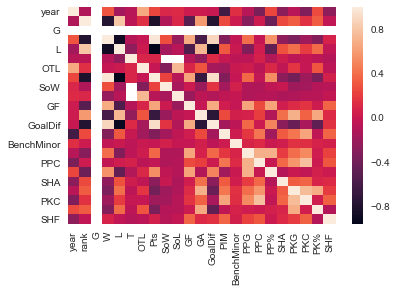

In [104]:
ax = sns.heatmap(data.corr()) 
#Taken from the Bank Marketing Logistic Example
#creates a heatmap that shows how correlated one variable is with another variable
#Check the independence between the feature variables

#### Heatmap Analysis

As shown in the heat map, ceartain variables such as Goals-For, Goals-Against, and Goal-Differential are highly correlated. This makes sense since Goal Differential is derived from these variables. The variables that we have chosen for our model do not show strong correlation with one another, which is a good sign that we chose appropriate variables during our preliminary analysis.

### Separating our target and feature variables

In [105]:
y = data[['W']]    # This pulls the target values from the dataset.

In [106]:
y.head()

,W
0,35
1,40
2,33
3,34
4,40


In [107]:
X1 = data[['GF']]
X2 = data[['GA']]
X3 = data[['GoalDif']]
X4 = data[['PIM']]
X5 = data[['BenchMinor']]
X6 = data[['PPG']]
X7 = data[['PPC']]
X8 = data[['PP%']]
X9 = data[['SHA']]
X10 = data[['PKG']]
X11 = data[['PKC']]
X12 = data[['PK%']]
X13 = data[['SHF']]    
# This pulls the feature values from the dataset.

In [108]:
X = np.c_[X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13] #concatenates all of the feature variables into an array

In [109]:
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)
#this code was borrowed and slightly adjusted from the Applying Learning Algorithms Class Demo
#This code takes the variable X, the feature values, and splits it into two sets:
#the training and test set, defined by the first two variables in the code
#We are taking 20% of the data set and using the random_state 42
#We will keep this random state constant throughout the assignment
#If we do not, the randomly chosen numbers will be different every time the data is invoked, which will provide 
#inconsistent and useless results

#### Checking Our Data

In [110]:
print(len(data), 'Total data size.')
print(len(train_set), "training cases.")
print(len(test_set), "testing cases.")
#prints the number of cases in our total data set, training set, and testing set

463 Total data size.
370 training cases.
93 testing cases.


In [111]:
#Pulling appropriate feature and target variables from split datasets.
#adapted from assignment 2

#The items that have been commented out were originally planned to be used, but our analysis determined that the 
#variables are closely related to other features
#These items remain in case they later need to be used for future analysis
y_train = train_set[['W']]    # This pulls the target values from the training set.
X1_train = train_set[['GF']]    # This pulls the feature values from the training set.
X2_train = train_set[['GA']]
#X3_train = train_set[['GoalDif']]
X4_train = train_set[['PIM']]
#X5_train = train_set[['BenchMinor']]
#X6_train = train_set[['PPG']]
#X7_train = train_set[['PPC']]
X8_train = train_set[['PP%']]
X9_train = train_set[['SHA']]
#X10_train = train_set[['PKG']]
#X11_train = train_set[['PKC']]
X12_train = train_set[['PK%']]
X13_train = train_set[['SHF']]    

y_test = test_set[['W']]    # This pulls the target values from the testing set.
X1_test = test_set[['GF']]    # This pulls the feature values from the testing set.
X2_test = test_set[['GA']]
#X3_test = test_set[['GoalDif']]
X4_test = test_set[['PIM']]
#X5_test = test_set[['BenchMinor']]
#X6_test = test_set[['PPG']]
#X7_test = test_set[['PPC']]
X8_test = test_set[['PP%']]
X9_test = test_set[['SHA']]
#X10_test = test_set[['PKG']]
#X11_test = test_set[['PKC']]
X12_test = test_set[['PK%']]
X13_test = test_set[['SHF']]  

In [112]:
#Converting to numpy arrays.
#adapted from assignment 2
y_train = np.array(y_train)
X1_train = np.array(X1_train)
X2_train = np.array(X2_train)
#X3_train = np.array(X3_train)
X4_train = np.array(X4_train)
#X5_train = np.array(X5_train)
#X6_train = np.array(X6_train)
#X7_train = np.array(X7_train)
X8_train = np.array(X8_train)
X9_train = np.array(X9_train)
#X10_train = np.array(X10_train)
#X11_train = np.array(X11_train)
X12_train = np.array(X12_train)
X13_train = np.array(X13_train)

y_test = np.array(y_test)
X1_test = np.array(X1_test)
X2_test = np.array(X2_test)
#X3_test = np.array(X3_test)
X4_test = np.array(X4_test)
#X5_test = np.array(X5_test)
#X6_test = np.array(X6_test)
#X7_test = np.array(X7_test)
X8_test = np.array(X8_test)
X9_test = np.array(X9_test)
#X10_test = np.array(X10_test)
#X11_test = np.array(X11_test)
X12_test = np.array(X12_test)
X13_test = np.array(X13_test)

In [113]:
X_train = np.c_[X1_train,X2_train,X4_train,X8_train,X9_train,X12_train,X13_train]
X_test = np.c_[X1_test,X2_test,X4_test,X8_test,X9_test,X12_test,X13_test]
#concatenates the relevant feature variables to the training and testing sets

#### Analysis

We originally planned to use all of the features that were encoded, but after careful analysis, we determined that the features we commented out are closely related to the other features in the model (see heatmap). We have decided to use the following features: Goals-For, Goals-Against, Short-Handed Goals-For, Short-Handed Goals-Against, Penalties-in-Minutes, PowerPlay Percentage, and Penalty-Kill Percentage.

### Scaling the Data

In [114]:
X_scale_Train = preprocessing.scale(X_train)
scaler = preprocessing.StandardScaler().fit(X_train) 
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
# Adapted from http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler
#and also adapted from the Applying Learning Algorithms Class Demo
#Scales the data so that the features do not bias the results (meaning that a feature that ranges from 800 to 1000 
#will not have more sway than a feature that runs from 10 to 20, ceteris paribus)

# Running Our Models

We have decided to evaluate the following models: Linear Regression, 2-Degree Polynomial, 7-Degree Polynomial, Lasso Regression, and Ridge Regression. We will compare their cost functions on the training data and select the best model for future calculations. The best model will perform well on the training and testing data, but we will choose one that does not appear to overfit the noise in the data. 

We are using these models because they all output numerical values that can be used for predictions. Other models, such as classification models, would have been inappropriate for the task of predicting the amount of wins in a season. A classification model would be better suited for predicting whether or not a team is likely to make the playoffs (this is a binary example).

## Linear Regression

In [115]:
#Create linearRegression object and fit it to your training data
#taken from Scikit-Learning and Nonlinear Models demo
lr = LinearRegression() #taken from Scikit-Learning and Nonlinear Models demo
lr.fit(X_train,y_train) #ties the X_train data with the y_train data to provide a correlation

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [116]:
#Displays the thetas
lr.intercept_, lr.coef_ #displays the bias and slope of the model

(array([38.1027027]),
 array([[ 5.34749648, -4.28585484, -1.35930265,  0.54622815,  0.02096787,
          0.23788088, -0.2708182 ]]))

#### Analysis

Looking at the interpretation of the fifth (short-handed goals allowed) and seventh (short-handed goals for) categories, the model does not make intuitive sense. We would think that by allowing more short-handed goals against, the team would likely win fewer games. In contrast, we would think that by increasing the amount of short-handed goals we score would make us more likely to win more games. This may indicate that linear regression is not the optimal model to use.

### Training Set

In [117]:
y_pred_lr = (lr.coef_.dot(X_train.T)) +lr.intercept_ #creates a variable that makes a prediction based on the 
                                                     #feature data

In [118]:
linreg_train = mean_squared_error(y_train.T,y_pred_lr)
print(linreg_train)

10.822907764556371


### Test Set

In [119]:
y_pred_lr = (lr.coef_.dot(X_test.T)) +lr.intercept_

In [120]:
linreg_test = mean_squared_error(y_test.T,y_pred_lr)
print(linreg_test)

9.876327883326493


## Second-Degree Polynomial

In [121]:
pf=PolynomialFeatures(degree=2, include_bias=False)
X_poly =pf.fit_transform(X_train) #fits to the data and then transforms it
lr.fit(X_poly, y_train) #fits the X polynomial data with the target training values
#polynomial features already imported, allows us to shape our best fit line to a polynomial with two degrees
#taken from the Scikit-Learning and Nonlinear Models demo

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [122]:
#Displays the thetas
lr.intercept_, lr.coef_

(array([38.34928983]),
 array([[ 5.32413379e+00, -4.25088516e+00, -1.47982706e+00,
          5.30948604e-01,  7.33980578e-02,  1.27149544e-01,
         -7.62731553e-02,  3.66901470e-02,  5.50248291e-01,
         -1.81558758e-01, -6.23638562e-01, -7.38747146e-02,
         -3.60314554e-01, -2.07604352e-01, -2.74404674e-01,
          4.02528232e-01, -3.90945490e-01,  2.93295573e-01,
          1.62047808e-01, -1.67238990e-01,  1.09265331e-01,
         -1.66110522e-01, -4.48909689e-01, -3.85474330e-01,
         -1.80476040e-01,  2.93149328e-01,  2.89318628e-01,
         -7.05292437e-04,  1.29222657e-01, -3.46382268e-03,
         -8.61495340e-02,  1.72519788e-01, -2.22461080e-02,
          3.45021573e-01, -3.30889373e-02]]))

### Train Set

In [123]:
y_poly_pred = (lr.coef_.dot(X_poly.T)) +lr.intercept_

In [124]:
poly2_train = mean_squared_error(y_train,y_poly_pred.T)
print(poly2_train)

10.086560257976933


### Test Set

In [125]:
X_poly_test =pf.fit_transform(X_test)
y_poly_pred_test = (lr.coef_.dot(X_poly_test.T)) +lr.intercept_

In [126]:
poly2_test = mean_squared_error(y_test.T,y_poly_pred_test)
print(poly2_test)

10.09986664661926


## Seventh-Degree Polynomial

In [127]:
pf=PolynomialFeatures(degree=7, include_bias=False)
X_poly7 =pf.fit_transform(X_train) #fits to the data and then transforms it
lr.fit(X_poly7, y_train) #fits the X polynomial data with the target training values
#polynomial features already imported, allows us to shape our best fit line to a polynomial with two degrees
#taken from the Scikit-Learning and Nonlinear Models demo

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [128]:
#Displays the thetas
lr.intercept_, lr.coef_

(array([39.81870316]),
 array([[ 3.96067028, -2.7600339 ,  0.48309037, ..., -0.07063452,
         -0.0340835 , -0.02205356]]))

### Train Set

In [129]:
y_poly7_pred = (lr.coef_.dot(X_poly7.T)) +lr.intercept_

In [130]:
poly7_train = mean_squared_error(y_train,y_poly7_pred.T)
print(poly7_train)

4.388000404863577e-23


### Test Set

In [131]:
X_poly7_test =pf.fit_transform(X_test)
y_poly7_pred_test = (lr.coef_.dot(X_poly7_test.T)) +lr.intercept_

In [132]:
poly7_test = mean_squared_error(y_test.T,y_poly7_pred_test) #A severe case of overfitting the data
print(poly7_test)

1843361.6970056791


## Lasso using Scikit-Learn

In [133]:
#This was taken from pg. 132 in the textbook
#Completely elimates the weights of the least important features
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha = 0.1)
lasso_reg.fit(X_train, y_train)
lasso_reg.intercept_, lasso_reg.coef_

(array([38.1027027]),
 array([ 5.19753212, -4.04095664, -1.35353208,  0.57863987, -0.        ,
         0.        , -0.1539975 ]))

#### Analysis

Again we see that an increase in a team's short-handed goals-for is actually decreasing the amount of projected wins for a team in this model. We would not recommend that a team intentionaly try to not score while shorthanded if the opportunity presents itself. It would be difficult to convince us to belive that scoring less while shorthanded would actually increase our odds of winning. 

It seems that this model found that the short-handed goals against and penalty-kill percentage categories are closely related to the other feature variables and have regressed the impact of those variables to zero. 

### Train Set

In [134]:
y_lasso_pred = lasso_reg.coef_.dot(X_train.T) +lasso_reg.intercept_

In [135]:
lasso_train = mean_squared_error(y_train,y_lasso_pred)
print(lasso_train)

10.89012251797208


### Test Set

In [136]:
y_lasso_pred_test = lasso_reg.coef_.dot(X_test.T) +lasso_reg.intercept_

In [137]:
lasso_test = mean_squared_error(y_test,y_lasso_pred_test)
print(lasso_test)

9.925253575852283


## Cholesky Solver Closed Form Solution

In [138]:
#This was taken from pg. 129 in the textbook
#Keeps the model weights as small as possible and keeps all the feature variables
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X_train,y_train)
ridge_reg.intercept_, ridge_reg.coef_ 

(array([38.1027027]),
 array([[ 5.31998838, -4.26110431, -1.35892456,  0.56518224,  0.01415338,
          0.22066426, -0.26282032]]))

#### Analysis

Yet again we see that allowing short-handed goals has a positive impact on our model and that increasing the amount of goals we score short-handed has a negative impact on our model. We should consider removing these features from the models to see if our models improve.

### Train Set

In [139]:
y_ridge_pred = ridge_reg.coef_.dot(X_train.T) +ridge_reg.intercept_

In [140]:
ridge_train = mean_squared_error(y_train.T,y_ridge_pred)
print(ridge_train)

10.823576970549146


### Test Set

In [141]:
y_ridge_pred_test = ridge_reg.coef_.dot(X_test.T) +ridge_reg.intercept_

In [142]:
ridge_test = mean_squared_error(y_test.T,y_ridge_pred_test)
print(ridge_test)

9.871033944340013


# Training Set Comparisons

In [143]:
print('The cost of linear regression on the training set is: ',linreg_train)
print('The cost of a 2-degree polynomial on the training set is: ',poly2_train)
print('The cost of 7-degree polynomial on the training set is: ',poly7_train)
print('The cost of lasso regression on the training set is: ',lasso_train)
print('The cost of ridge regression on the training set is: ',ridge_train)

The cost of linear regression on the training set is:  10.822907764556371
The cost of a 2-degree polynomial on the training set is:  10.086560257976933
The cost of 7-degree polynomial on the training set is:  4.388000404863577e-23
The cost of lasso regression on the training set is:  10.89012251797208
The cost of ridge regression on the training set is:  10.823576970549146


#### Analysis

It is clear from the results that the seventh-degree polynomial outperformed all other models on the training set, however, it is very possible that this result is due to the model overfitting the data. We will be able to better see if this is the case when we run the model on the test set.

All other models have a similar cost with the second-degree polynomial seeming to have the best result. The second-degree polynomial model is performing at a cost of 10.087 while the linear, lasso, and ridge models are performing at 10.823, 10.890, and 10.824 respectively. From this, the frontrunner for our choice of a model is currently the second-degree polynomial. We will see if this pattern holds when we evaluate the models on the testing set.

# Test Set Comparisons

In [144]:
print('The cost of linear regression on the test set is: ',linreg_test)
print('The cost of a 2-degree polynomial on the test set is: ',poly2_test)
print('The cost of 7-degree polynomial on the test set is: ',poly7_test)
print('The cost of lasso regression on the test set is: ',lasso_test)
print('The cost of ridge regression on the test set is: ',ridge_test)

The cost of linear regression on the test set is:  9.876327883326493
The cost of a 2-degree polynomial on the test set is:  10.09986664661926
The cost of 7-degree polynomial on the test set is:  1843361.6970056791
The cost of lasso regression on the test set is:  9.925253575852283
The cost of ridge regression on the test set is:  9.871033944340013


### Results

Although the seventh-degree polynomial has the lowest cost on the training set, it exhibits the highest cost on the test set. This is a sign that the model is likely overfitting the data. Thus, we will not use this model going forward.

These results show us that although the second-degree polynomial performs the best on our training set, other models perform better on the test set. However, this performance is unusual. Models usually perform slightly worse on the testing set because we expect the model to overfit the data at least a little bit. Because of this reason, and because the models are all approximately within two-tenths of each other, we will likely choose to use the second-degree polynomial for our future models.

But first, we want to see if removing the short-handed feature variables will make a difference in our regression models.

## Removing Short-handed Feature Variables

In [145]:
X_train2 = np.c_[X1_train,X2_train,X4_train,X8_train,X12_train]
X_test2 = np.c_[X1_test,X2_test,X4_test,X8_test,X12_test]
#X_scale_Train2 = preprocessing.scale(X_train2)
#X_scale_Test2 = preprocessing.scale(X_test2)
#X_train2 = X_scale_Train2
#X_test2 = X_scale_Test2

In [146]:
scaler2 = preprocessing.StandardScaler().fit(X_train2) 
X_train2 = scaler2.transform(X_train2)
X_test2 = scaler2.transform(X_test2)

### Linear Regression

In [147]:
#Create linearRegression object and fit it to your training data
#taken from Scikit-Learning and Nonlinear Models demo
lr = LinearRegression() #taken from Scikit-Learning and Nonlinear Models demo
lr.fit(X_train2,y_train) #ties the X_train data with the y_train data to provide a correlation
lr.intercept_, lr.coef_

(array([38.1027027]),
 array([[ 5.20231265, -4.30453277, -1.42224624,  0.6172244 ,  0.26256171]]))

#### Analysis

After removing the short-handed goals-for and the short-handed goals-against categories, all of our feature variables trend in the direction we would expect. We will run the model to see how it performs relative to the linear regression model that included these two features.

### Training Set

In [148]:
y_pred_lr = (lr.coef_.dot(X_train2.T)) +lr.intercept_ #creates a variable that makes a prediction based on the 
                                                     #feature data

In [149]:
linreg_train2 = mean_squared_error(y_train.T,y_pred_lr)
print(linreg_train2)

10.875139246850242


In [150]:
print('The cost of the original linear regression model on the training set is: ',linreg_train)
print('The cost of the new linear regression on the training set is: ',linreg_train2)

The cost of the original linear regression model on the training set is:  10.822907764556371
The cost of the new linear regression on the training set is:  10.875139246850242


#### Analysis

It appears that by removing the two variables from our model, there is a slightly greater cost on our training set. We will see if this also holds for our testing set.

### Test Set

In [151]:
y_pred_lr = (lr.coef_.dot(X_test2.T)) +lr.intercept_

In [152]:
linreg_test2 = mean_squared_error(y_test.T,y_pred_lr)
print(linreg_test2)

9.874845664199519


In [153]:
print('The cost of the original linear regression model on the test set is: ',linreg_test)
print('The cost of the new linear regression on the test set is: ',linreg_test2)

The cost of the original linear regression model on the test set is:  9.876327883326493
The cost of the new linear regression on the test set is:  9.874845664199519


#### Analysis

Our new model performs slightly better than our original model on the test set. It seems like removing the two features was a good idea, at least for this model. We will see if this is true for the other models.

### Lasso Regression

In [154]:
lasso_reg = Lasso(alpha = 0.1)
lasso_reg.fit(X_train2, y_train)
lasso_reg.intercept_, lasso_reg.coef_

(array([38.1027027]),
 array([ 5.11288911, -4.04541494, -1.39506347,  0.62147946,  0.        ]))

#### Analysis

This model regresses the penalty-kill percentage category down to zero so that the category does not have an impact on the model. This is consistent with the features that the original Lasso Regression model regressed.

### Training Set

In [155]:
y_lasso_pred_train2 = lasso_reg.coef_.dot(X_train2.T) +lasso_reg.intercept_

In [156]:
lasso_train2 = mean_squared_error(y_train,y_lasso_pred_train2)
print(lasso_train2)

10.93682752340272


In [157]:
print('The cost of the original lasso regression model on the training set is: ',lasso_train)
print('The cost of the new lasso regression on the training set is: ',lasso_train2)

The cost of the original lasso regression model on the training set is:  10.89012251797208
The cost of the new lasso regression on the training set is:  10.93682752340272


#### Analysis

Like the linear regression model, the original model including the short-handed feature variables is performing better on the training set than the new model.

### Test Set

In [158]:
y_lasso_pred_test2 = lasso_reg.coef_.dot(X_test2.T) +lasso_reg.intercept_
lasso_test2 = mean_squared_error(y_test,y_lasso_pred_test2)
print(lasso_test2)

9.958145161796107


In [159]:
print('The cost of the original lasso regression model on the test set is: ',lasso_test)
print('The cost of the new lasso regression on the test set is: ',lasso_test2)

The cost of the original lasso regression model on the test set is:  9.925253575852283
The cost of the new lasso regression on the test set is:  9.958145161796107


#### Analysis

The new lasso model does not perform as well as the original model on the test set. However, this difference is very small. We will apply the same steps on the ridge regression model for completion, but we assume that it will produce similar results.

### Ridge Regression

In [160]:
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X_train2,y_train)
ridge_reg.intercept_, ridge_reg.coef_ 

(array([38.1027027]),
 array([[ 5.17934774, -4.28228148, -1.42121693,  0.63351071,  0.24621066]]))

#### Analysis

As predicted, the feature variables are oriented in the expected direction.

### Testing Set

In [161]:
y_ridge_pred2 = ridge_reg.coef_.dot(X_train2.T) +ridge_reg.intercept_
ridge_train2 = mean_squared_error(y_train.T,y_ridge_pred2)
print(ridge_train2)

10.875705194587438


In [162]:
print('The cost of the original ridge regression model on the training set is: ',ridge_train)
print('The cost of the new ridge regression on the training set is: ',ridge_train2)

The cost of the original ridge regression model on the training set is:  10.823576970549146
The cost of the new ridge regression on the training set is:  10.875705194587438


#### Analysis

Once again, the new model performs slightly worse on the training data, but the difference is very small. 

### Testing Set

In [163]:
y_ridge_pred_test2 = ridge_reg.coef_.dot(X_test2.T) +ridge_reg.intercept_
ridge_test2 = mean_squared_error(y_test.T,y_ridge_pred_test2)
print(ridge_test2)

9.876058000020546


In [164]:
print('The cost of the original ridge regression model on the test set is: ',ridge_test)
print('The cost of the new ridge regression on the test set is: ',ridge_test2)

The cost of the original ridge regression model on the test set is:  9.871033944340013
The cost of the new ridge regression on the test set is:  9.876058000020546


#### Analysis

The new model performs only slightly worse on the test set than the original model. Although the model does not perform as well, we still consider it an improvement over the original model since we know it makes intuitive sense. 

# Model Comparisons

#### Analysis

We will be comparing the new linear, lasso, and ridge regression models with the original 2-degree polynomial model. We have already determined that the 7-degree polynomial is overfitting the data and should not be selected.

### New Training Set Comparisons

In [165]:
print('The cost of the new linear regression model on the training set is: ',linreg_train2)
print('The cost of the new lasso regression model on the training set is: ',lasso_train2)
print('The cost of the new ridge regression model on the training set is: ',ridge_train2)
print('The cost of the 2-degree polynomial model on the training set is: ',poly2_train)

The cost of the new linear regression model on the training set is:  10.875139246850242
The cost of the new lasso regression model on the training set is:  10.93682752340272
The cost of the new ridge regression model on the training set is:  10.875705194587438
The cost of the 2-degree polynomial model on the training set is:  10.086560257976933


### New Test Set Comparisons

In [166]:
print('The cost of the new linear regression model on the test set is: ',linreg_test2)
print('The cost of the new lasso regression model on the test set is: ',lasso_test2)
print('The cost of the new ridge regression model on the test set is: ',ridge_test2)
print('The cost of the 2-degree polynomial model on the test set is: ',poly2_test)

The cost of the new linear regression model on the test set is:  9.874845664199519
The cost of the new lasso regression model on the test set is:  9.958145161796107
The cost of the new ridge regression model on the test set is:  9.876058000020546
The cost of the 2-degree polynomial model on the test set is:  10.09986664661926


#### Analysis

After modifying our linear, lasso, and ridge regression models, the second-degree polynomial continues to perform best on the our training data by a margin of eight- to nine-tenths. 

We normally assume that models will perform worse on the testing set since models tend to overfit noise in the training data. 
Of all the models, only the second-degree polynomial performs in this expected manner. 
Because of this, we would expect all of the models to perform worse on the testing data. Since the results of the linear, lasso,and ridge regression models do not perform as expected, we are hesitant to choose any of the models besides the second-degree polynomial. Even so, there is not too much of a performance distance between the models (the difference between linear regression and second-degree polynomial is about 0.225). 

For these reasons, we will use the second-degree polynomial model as our model of choice for the final steps of the project.

## Extra Predictions

In the following section, we will use data for several Tampa Bay Lightning seasons that were not included in our original data set. We will run the data through the second-degree polynomial model to further see how well the model performs.

### Tampa Bay Lighning 2011 - 2012 Season Prediction

In [167]:
TB12_Wins = 46
TB12_GF = 232
TB12_GA = 209
TB12_PIMS = 844
TB12_PPP = 18.5
TB12_SHA = 8
TB12_PKP = 80.7
TB12_SHF = 10


#taken from:
#http://www.nhl.com/stats/team?reportType=season&seasonFrom=20172018&seasonTo=20172018&gameType=2&filter=gamesPlayed,gte,1&sort=points,wins
#http://www.espn.com/nhl/statistics/team/_/stat/major-penalties/sort/PIM/year/2018/seasontype/2
#http://www.espn.com/nhl/statistics/team/_/stat/special-teams

In [168]:
TB_2012 = np.c_[TB12_GF,TB12_GA,TB12_PIMS,TB12_PPP,TB12_SHA,TB12_PKP,TB12_SHF] 
#concatenating the categories

In [169]:
TB_2012_scaled = scaler.transform(TB_2012)
TB_2012 = TB_2012_scaled
scaler.transform(TB_2012)
TB_2012 = TB_2012.reshape(1,-1)
#This code is scaling the new data to match the scale of the training data

In [170]:
pf=PolynomialFeatures(degree=2, include_bias=False)
TB_2012_poly =pf.fit_transform(TB_2012) #fits to the data and then transforms it
lr.fit(X_poly, y_train) #fits the X polynomial data with the target training values
#polynomial features already imported, allows us to shape our best fit line to a polynomial with two degrees
#taken from the Scikit-Learning and Nonlinear Models demo

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [171]:
y_poly_TB2012 = (lr.coef_.dot(TB_2012_poly.T)) +lr.intercept_

In [172]:
print('Our Model estimates that the Tampa Bay Lightning won', int(y_poly_TB2012), 'games in the 2011-2012 season')
print('Tampa Bay actually won', TB12_Wins, 'games in the 2011-2012 season')

Our Model estimates that the Tampa Bay Lightning won 49 games in the 2011-2012 season
Tampa Bay actually won 46 games in the 2011-2012 season


### Tampa Bay Lightning 2016 - 2017 Season Prediction

In [173]:
TB17_Wins = 42
TB17_GF = 230
TB17_GA = 224
TB17_PIMS = 875
TB17_PPP = 22.8
TB17_SHA = 8
TB17_PKP = 81.4
TB17_SHF = 4


#taken from:
#http://www.nhl.com/stats/team?reportType=season&seasonFrom=20172018&seasonTo=20172018&gameType=2&filter=gamesPlayed,gte,1&sort=points,wins
#http://www.espn.com/nhl/statistics/team/_/stat/major-penalties/sort/PIM/year/2018/seasontype/2
#http://www.espn.com/nhl/statistics/team/_/stat/special-teams

In [174]:
TB_2017 = np.c_[TB17_GF,TB17_GA,TB17_PIMS,TB17_PPP,TB17_SHA,TB17_PKP,TB17_SHF] 
#concatenating the categories

In [175]:
TB_2017_scaled = scaler.transform(TB_2017)
TB_2017 = TB_2017_scaled
scaler.transform(TB_2017)
TB_2017 = TB_2017.reshape(1,-1)
#This code is scaling the new data to match the scale of the training data

In [176]:
pf=PolynomialFeatures(degree=2, include_bias=False)
TB_2017_poly =pf.fit_transform(TB_2017) #fits to the data and then transforms it
lr.fit(X_poly, y_train) #fits the X polynomial data with the target training values
#polynomial features already imported, allows us to shape our best fit line to a polynomial with two degrees
#taken from the Scikit-Learning and Nonlinear Models demo

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [177]:
y_poly_TB2017 = (lr.coef_.dot(TB_2017_poly.T)) +lr.intercept_

In [178]:
print('Our Model estimates that the Tampa Bay Lightning won', int(y_poly_TB2017), 'games in the 2016-2017 season')
print('Tampa Bay actually won', TB17_Wins, 'games in the 2016-2017 season')

Our Model estimates that the Tampa Bay Lightning won 37 games in the 2016-2017 season
Tampa Bay actually won 42 games in the 2016-2017 season


### Tampa Bay Lighning 2017 - 2018 Season Prediction

In [179]:
TB18_Wins = 54
TB18_GF = 296
TB18_GA = 236
TB18_PIMS = 753
TB18_PPP = 23.9
TB18_SHA = 3
TB18_PKP = 76.1
TB18_SHF = 9

#taken from:
#http://www.nhl.com/stats/team?reportType=season&seasonFrom=20172018&seasonTo=20172018&gameType=2&filter=gamesPlayed,gte,1&sort=points,wins
#http://www.espn.com/nhl/statistics/team/_/stat/major-penalties/sort/PIM/year/2018/seasontype/2
#http://www.espn.com/nhl/statistics/team/_/stat/special-teams

In [180]:
TB_2018 = np.c_[TB18_GF,TB18_GA,TB18_PIMS,TB18_PPP,TB18_SHA,TB18_PKP,TB18_SHF] 
#concatenating the categories

In [181]:
TB_2018_scaled = scaler.transform(TB_2018)
TB_2018 = TB_2018_scaled
scaler.transform(TB_2018)
TB_2018 = TB_2018.reshape(1,-1)
#This code is scaling the new data to match the scale of the training data

In [182]:
pf=PolynomialFeatures(degree=2, include_bias=False)
TB_2018_poly =pf.fit_transform(TB_2018) #fits to the data and then transforms it
lr.fit(X_poly, y_train) #fits the X polynomial data with the target training values
#polynomial features already imported, allows us to shape our best fit line to a polynomial with two degrees
#taken from the Scikit-Learning and Nonlinear Models demo

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [183]:
y_poly_TB2018 = (lr.coef_.dot(TB_2018_poly.T)) +lr.intercept_

In [184]:
print('Our Model estimates that the Tampa Bay Lightning won', int(y_poly_TB2018), 'games in the 2017-2018 season')
print('Tampa Bay actually won', TB18_Wins, 'games in the 2017-2018 season')

Our Model estimates that the Tampa Bay Lightning won 46 games in the 2017-2018 season
Tampa Bay actually won 54 games in the 2017-2018 season


### Tampa Bay Lighning 2018 - 2019 Season Prediction

This season has not yet happened. We will attempt to predict the amount of wins the Tampa Bay Lightning will have next season based off of summed averages of the players' career goals for, penalties-in-minutes, and short-handed goals-for. We will use the 2017-2018 season's statistics as inputs for the other feature variables.

In [185]:
TB19_GF = 13/4 + 179/12 + 5/1 + 28/6 + 31/3 + 110/6 + 87/6 + 147/5 + 82/6 + 85/6 + 50/2 + 348/10 + 44/13 + 3/2 + 52/12 + 82/9 + 53/8 + 9/1 + 45/11
TB19_GA = 236
TB19_PIMS = 214/4 + 414/12 + 6/1 + 112/6 + 60/3 + 126/6 + 268/6 + 161/5 + 156/6 + 109/6 +  38/2 +  440/10 + 656/13 + 73/2 +  302/12 + 485/9 + 221/8 + 38/1 + 243/11
TB19_PPP = 23.9
TB19_SHA = 3
TB19_PKP = 76.1
TB19_SHF = 9

# Statistics estimated from https://www.nhl.com/lightning/roster

In [186]:
TB_2019 = np.c_[TB19_GF,TB19_GA,TB19_PIMS,TB19_PPP,TB19_SHA,TB19_PKP,TB19_SHF] 
#concatenating the categories

In [187]:
TB_2019_scaled = scaler.transform(TB_2019)
TB_2019 = TB_2019_scaled
scaler.transform(TB_2019)
TB_2019 = TB_2019.reshape(1,-1)
#This code is scaling the new data to match the scale of the training data

In [188]:
pf=PolynomialFeatures(degree=2, include_bias=False)
TB_2019_poly =pf.fit_transform(TB_2019) #fits to the data and then transforms it
lr.fit(X_poly, y_train) #fits the X polynomial data with the target training values
#polynomial features already imported, allows us to shape our best fit line to a polynomial with two degrees
#taken from the Scikit-Learning and Nonlinear Models demo

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [189]:
y_poly_TB2019 = (lr.coef_.dot(TB_2019_poly.T)) +lr.intercept_

In [190]:
print('Based on our model, we expect the Tampa Bay Lightning to win', int(y_poly_TB2019), 'games next season')

Based on our model, we expect the Tampa Bay Lightning to win 60 games next season


## Applying Our Model

In [191]:
def wins_predict():
    '''Predicts the amount of wins a team will win in a season'''
    
    #The following code will take 8 user inputs
    TeamName = input('Enter the name of your team: ')
    flag = 0
    while flag == 0:
        try:
            GF = float(input('Enter the amount of goals you predict your team will score: '))
            GA = float(input('Enter the amount of goals you predict your team will have scored on them: '))
            SHF = float(input('Enter the amount of shorthanded goals you think your team will score next season: '))
            SHA = float(input('Enter the amount of shorthanded goals you think your team will allow next season: '))
            PIMS = float(input('Enter the amount of penalties-in-minutes you predict your team will accumulate: '))
            PPP = float(input('Enter an estimate for your PowerPlay Percentage next season (ex: 21.3): '))
            PKP = float(input('Enter an estimate for your Penalty-Kill Percentage next season (ex: 82.6): '))
            flag = 1
        except ValueError:
            print('You did not enter a proper value. Please run the function again.')
            return
        #This was written ourselves. It allows you to enter in values to see how well your team will perform

    
    
    Season = np.c_[GF,GA,PIMS,PPP,SHA,PKP,SHF] #concatenating the categories
    Season_scaled = scaler.transform(Season)
    Season = Season_scaled
    scaler.transform(Season)
    Season = Season.reshape(1,-1) #This code is scaling the new data to match the scale of the training data
    
    pf=PolynomialFeatures(degree=2, include_bias=False)
    Season_poly =pf.fit_transform(Season) #fits to the data and then transforms it
    lr.fit(X_poly, y_train) #fits the X polynomial data with the target training values
    #polynomial features already imported, allows us to shape our best fit line to a polynomial with two degrees
    #taken from the Scikit-Learning and Nonlinear Models demo
    
    y_poly_Season = (lr.coef_.dot(Season_poly.T)) +lr.intercept_
    
    #Displays the user inputs as a reminder of the inputted data
    #and to provide an easy way to conduct a sensitivity analysis
    print('')
    print('Your inputted values:')
    print('Team Name:', TeamName)
    print('Goals For:', GF)
    print('Goals Against: ', GA)
    print('Short-Handed Goals-For: ',SHF)
    print('Short-Handed Goals-Against: ',SHA)
    print('Penalties-in-Minutes: ', PIMS)
    print('PowerPlay Percentage: ',PPP)
    print('Penalty-Kill Percentage: ',PKP)
    print('')
    print('Based on our model, we expect your team to win', int(y_poly_Season), 'games next season')
    if 82 >= y_poly_Season > 65:
        print('')
        print('You are expected to win a large amount of games. You may want to reevaluate your inputs.')
    elif y_poly_Season > 82:
        print('')
        print('You are expected to win more games than possible. We strongly recommend reevaluating your inputs to make sure that they seem realistic')

In [192]:
wins_predict()

Enter the name of your team: TBL
Enter the amount of goals you predict your team will score: 220
Enter the amount of goals you predict your team will have scored on them: 350
Enter the amount of shorthanded goals you think your team will score next season: 4
Enter the amount of shorthanded goals you think your team will allow next season: 6
Enter the amount of penalties-in-minutes you predict your team will accumulate: 1200
Enter an estimate for your PowerPlay Percentage next season (ex: 21.3): 20
Enter an estimate for your Penalty-Kill Percentage next season (ex: 82.6): 81.5

Your inputted values:
Team Name: TBL
Goals For: 220.0
Goals Against:  350.0
Short-Handed Goals-For:  4.0
Short-Handed Goals-Against:  6.0
Penalties-in-Minutes:  1200.0
PowerPlay Percentage:  20.0
Penalty-Kill Percentage:  81.5

Based on our model, we expect your team to win 15 games next season


# Conclusion

We conclude that by using the second-degree polynomial model, General Managers of the National Hockey League will be able to have an accurate prediction of how many games their team is likely to win. Since the cost function on the testing set of this model is roughly 10.1, it means that the model is accurate to within +/- 3.26 games on average (root mean squared error). While we see that it does hold true for the 2012 model (the projection is three goals more than they actually won), we see that it is off by 5 games for the 2017 model, and by 8 games for the 2018 model. One possible reason for this is that the hockey has evolved and thus has made the data set less relevent (our data runs from 1995 to 2011). Another reason could be that the Tampa Bay Lightning is a slight outlier for the model: the Lightning performed exceptionally well during the 2017-2018 regular season. 

Nevertheless, the model does provide a good estimate for how many games a team will win in a season. In practice, GMs could take a sum of their players' individual statistics to predict the team's goals-for, goals-against, powerplay percentage, penalty kill percentage, penalties-in-minutes, short-handed goals-for, and short-handed goals-against, and then plug those results into the model. This would allow the GM to predict their team's wins for the upcoming season. We did this for the Tampa Bay Lightning and we expect them to win 60 games next season (as Tampa Bay fans, we sincerely hope that this prediction is true).

The General Manager could also complete this same process for all teams in their division, conference, or even the entire league to predict the final standings for that season. This would provide GMs a good idea of how likely they are to make the playoffs that year. 

The General Manager would be able to use this model to evaluate the value of potential trades. They could remove the stats of the players that they are giving up from the projected average used to calculate the results of the upcoming season and then include the projected statistics of the players that they would potentially gain from the trade. The GM could then see how this trade is likely to affect the team's wins in the upcoming season. If the team were to make a trade mid-season, they could simply pro-rate the necessary calculations to predict the amount of wins at the end of the season.

A downside to using this model is that it does not specifically account for players who may not have good chemistry with the other players in the organization. If the GM trades for a player that does not fit into the system and does not perform as well as they usually do, the actual amount of wins the team has may end up varying significantly from the projected amount of wins. However, the converse of this is also true: a player may fit very well with the organization and exceed expectations. This same line of thinking also applies to players who may go into a slump next season and players who might have a breakout season. Finally, one last downside is that the model will have trouble predicting if players have not yet played a significant number of seasons in the NHL and values used within the model are inaccurate. However, these are not faults of the model and are instead faults of the input data. It is our belief that using this model would provide a General Manager with much more insight that they would have if they were to simply follow their gut instinct or use other traditional methods, which are subject to the same downsides as our model.  

By using our second-degree polynomial model, General Managers will have a good idea of how well the team is likely to perform in upcoming seasons. The GMs could use this information to make smart trades that are likely to improve the team's record. Although the model is not without defects, these defects are not due to the model itself and are instead due to unpredictible events that are difficult to forecast. Additional models may be created in the future that, when combined with our model, help to improve our model's accuracy and provide General Managers with more accurate insight. In all, this model appears to do well at measuring what it purports to measure, and so will help General Managers bring a little more certainty into a game that is riddled with uncertainty.

